In [54]:
# import necessary libraries
import pandas as pd # handle tabular data (DataFrame)
import numpy as np
import gensim # NLP library, includes Word2Vec
import matplotlib.pyplot as plt # visualization

# import modules from scikit-learn
from sklearn.decomposition import PCA # dimensionality reduction
from sklearn.model_selection import train_test_split # split the  into training and testing
from sklearn.cluster import KMeans

# import Word2Vec from Gensim to train word embeddings
from gensim.models import Word2Vec

# import umap
import umap.umap_ as umap
# import seaborn
import seaborn as sns

In [55]:
!pip install umap-learn
!pip install seaborn

### Data Preprocessing

In [56]:
# data path
data_path = "/content/Online Retail.xlsx"
# read the excel file and load the dataset into Pandas Dataframe
df = pd.read_excel(data_path)
df
print(df['StockCode'].nunique())

4070


In [57]:
# check for missing values
print(df.isnull().sum())
print(len(df))

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64
541909


#### Since CustomerID is missing in 135,080 rows, we replace the missing values with -1

In [69]:
# fill missing values in the "CustomerID" column with -1
df = df.assign(CustomerID=df["CustomerID"].fillna(-1).astype(int))

# filter quantity and unitprice > 0
df = df[df['Quantity'] > 0]
df = df[df['UnitPrice'] > 0]

# remove rows where "Descripton" is missing
df["Description"] = df["Description"].replace(["NaN", "None"], np.nan)
df = df.dropna(subset=["Description"])

# convert product descriptions to lowercase for consistency
df.loc[:,"Description"] = df["Description"].str.lower()

# convert "StockCode" to string format
df.loc[:,'StockCode'] = df['StockCode'].astype(str)

# # group by 'InvoiceNo' and collect unique 'StockCode' values for each invoice
data = df.groupby('InvoiceNo')['StockCode'].apply(lambda x: list(set(x))).reset_index(name='products')

### Explanation

#### Explanation
#### Grouping by 'InvoiceNo' ensures that products purchased together in the same transaction remain grouped. This helps capture co-purchase patterns and maintains meaningful relationships between products.

#### Additionally, grouping prevents data leakage when splitting into train and test sets.
#### Without grouping, products from the same transaction could end up in both sets, leading to inflated accuracy. By keeping transactions intact, we improve the reliability of train-test splitting and model performance.


In [59]:
# view data
data

,InvoiceNo,products
0,536365,"[22752, 71053, 21730, 84406B, 85123A, 84029G, ..."
1,536366,"[22633, 22632]"
2,536367,"[84969, 21777, 22623, 21754, 48187, 22748, 227..."
3,536368,"[22914, 22912, 22960, 22913]"
4,536369,[21756]
...,...,...
19955,581584,"[20832, 85038]"
19956,581585,"[22113, 84946, 16016, 22466, 22178, 22727, 233..."
19957,581586,"[20685, 22061, 23275, 21217]"
19958,581587,"[22556, 22631, 22138, 22726, 22629, 22555, 223..."


### Build model

In [60]:
# split the dataset into training and testing sets
# 'products' column contains lists of unique StockCodes per invoice
# 90% of the data is used for training, 10% is used for testing, 'random_state=42' ensures reproducibility of the split

train_invoices, test_invoices = train_test_split(data['InvoiceNo'], test_size=0.1, random_state=42)

In [61]:
# Create train and test sets
train_df = data[data['InvoiceNo'].isin(train_invoices)]
test_df = data[data['InvoiceNo'].isin(test_invoices)]

train_products = train_df['products'].tolist()
test_products = test_df['products'].tolist()

In [62]:
# train a Word2Vec model on the training invoices
# 'vector_size=100' sets the dimensionality of the word embeddings to 100, 'window=5' defines the maximum distance between a target word and its neighboring words, 'min_count=5' ignores words (StockCodes) that appear less than 5 times in the dataset
# 'workers=4' enables parallel processing using 4 CPU cores to speed up training

model = Word2Vec(sentences = train_products, vector_size=100, window=5, min_count=5, workers=4)

### Visualize word2vec Embeddings

### PCA

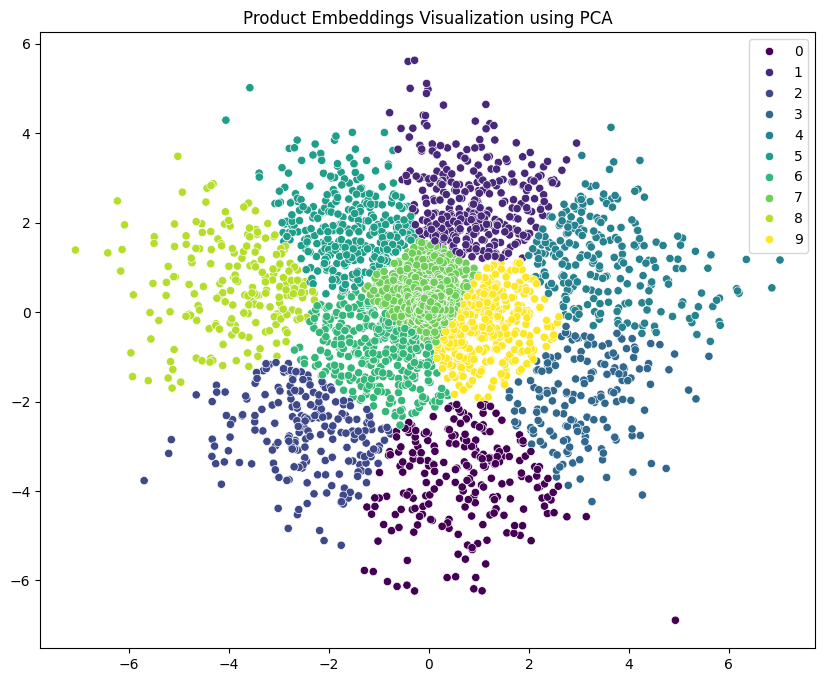

In [63]:
products = model.wv.index_to_key
# retrieve the corresponding word vectors for each product
embeddings = [model.wv[product] for product in products]

# using PCA to reduce dimension from 100D to 2D for visualization
pca = PCA(n_components=2)
embeddings_2d_pca = pca.fit_transform(embeddings)

# use KMeans
num_clusters = 10  # number of clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(embeddings_2d_pca)

# create a scatter plot to visualize the 2D embeddings of products
plt.figure(figsize=(10,8))
sns.scatterplot(x=embeddings_2d_pca[:, 0], y=embeddings_2d_pca[:, 1], hue=cluster_labels,  # assign colors based on cluster labels
    palette="viridis",   # a predefined color palette
    legend="full")

# add title
plt.title('Product Embeddings Visualization using PCA')
plt.show()

### UMAP

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


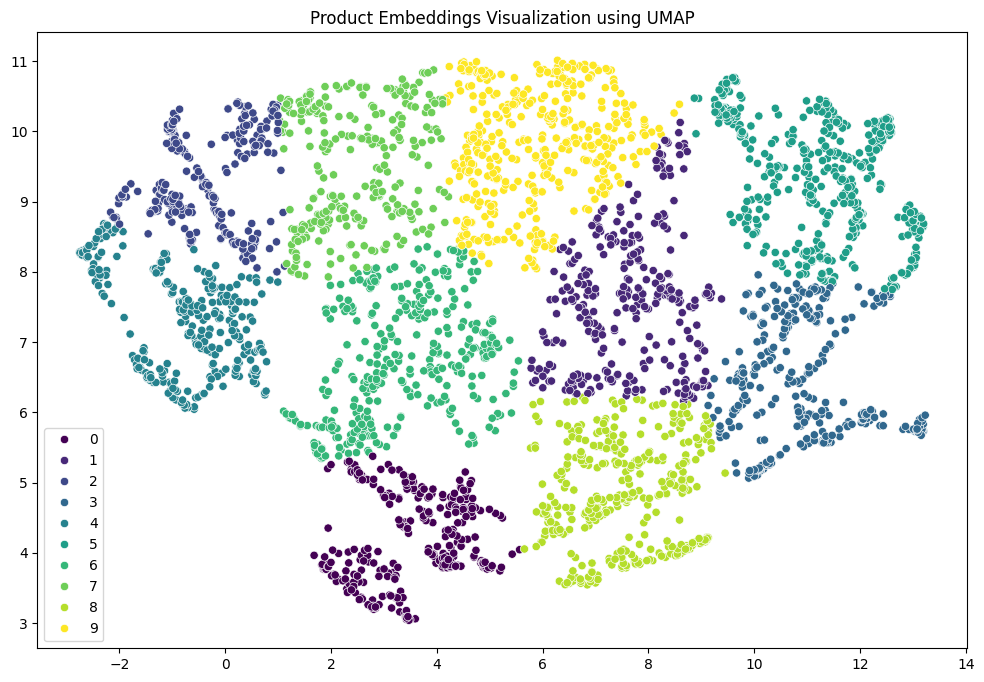

In [64]:
# reduce dimension using UMAP
words = list(model.wv.index_to_key)
word_vectors = model.wv[words]

umap_model = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1)
embeddings_2d_umap = umap_model.fit_transform(word_vectors)

# use KMeans
num_clusters = 10
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(embeddings_2d_umap)

# visualization
plt.figure(figsize=(12, 8))
sns.scatterplot(x=embeddings_2d_umap[:, 0], y=embeddings_2d_umap[:, 1],  hue=cluster_labels,
    palette="viridis",
    legend="full")
plt.title('Product Embeddings Visualization using UMAP')
plt.show()

### Build a function to compute product similarity

In [65]:
# compute the similarity of products
def get_similar_products(product, top_n=5):
    # check if the given product exists in the Word2Vec vocabulary
    if product in model.wv:
        # return the top n most similar products based on cosine similarity
        return model.wv.most_similar(product, topn=top_n)
    else:
        return []

### Build a function to compute products recommendation

In [66]:
# customer-based recommendations
def recommend_for_customer(product_ids, top_n):
    # filter out products that are not in the model's vocabulary
    valid_products = [pid for pid in product_ids if pid in model.wv]
    if not valid_products:
        return []
    # compute the average vector presentation of all valid products
    avg_vector = np.mean([model.wv[pid] for pid in valid_products], axis=0)
    # return the top_n most similar products to the computed average based on cosine similarity
    return model.wv.similar_by_vector(avg_vector, topn=top_n)

In [67]:
# examples
# single product similarity
similar = get_similar_products('85123A', top_n=5)
print("Similar to '85123A':", similar)

# multi-product recommendation
recommended = recommend_for_customer(['85123A', '71053'], top_n=5)
print("Recommended products:", recommended)

Similar to '85123A': [('48194', 0.9218969345092773), ('48173C', 0.9077757596969604), ('22762', 0.8899857401847839), ('22171', 0.8611739277839661), ('22602', 0.8429924249649048)]
Recommended products: [('85123A', 0.9309410452842712), ('48187', 0.9217614531517029), ('23330', 0.9165648818016052), ('22762', 0.9069890379905701), ('22426', 0.9033343195915222)]


### Manually checking

In [68]:
# check by calculate cosine similarity between 2 vector
def cosine_similarity(vec1, vec2):
    dot_product = np.dot(vec1, vec2)  # compute dot product
    norm_vec1 = np.linalg.norm(vec1)  # vector 1
    norm_vec2 = np.linalg.norm(vec2)  # vector 2

    if norm_vec1 == 0 or norm_vec2 == 0:  # avoid divide to 0
        return 0.0

    return dot_product / (norm_vec1 * norm_vec2)

# examples
vec_1 = model.wv['85123A']
vec_2 = model.wv['71053']

vec_b = model.wv['23056']
mean = np.mean([vec_1,vec_2],axis=0)

# calculate cosine similarity
similarity = cosine_similarity(mean, vec_b)
print(f"Cosine Similarity: {similarity:.4f}")
similarity = cosine_similarity(vec_1, vec_b)
print(f"Cosine Similarity: {similarity:.4f}")



Cosine Similarity: 0.4543
Cosine Similarity: 0.4092


### Discussion

##### This result is based on the vector of a single product. What happens if we want to recommend products to a customer based on the products they have previously chosen?

#### **Recommendations Based on Previously Chosen Products**
#### If we want to recommend products to a customer based on the products they have previously chosen, we can solve this problem using the following approach:
#### **Approach:**
#### 1. **Aggregate Embeddings**: Compute the average Word2Vec embedding of all products chosen by the customer to create a composite preference vector.  
#### 2. **Filter Valid Products**: Exclude products that are not present in the model's vocabulary.  
#### 3. **Similarity Search**: Identify products with the highest cosine similarity to the averaged vector in the embedding space.
#### **Explanation**
#### - Word2Vec embeddings capture contextual relationships between products.  
#### - Averaging these embeddings effectively blends multiple product contexts into a unified preference.  
#### - **Advanced techniques** such as weighted averaging and hybrid methods can further enhance recommendations, especially for handling cold-start products.

#### **Example:**
#### Suppose a customer previously purchased products with IDs '85123A' and '71053'.
#### We retrieve their embeddings from the trained Word2Vec model:
##### vec_1 = model.wv['85123A']
##### vec_2 = model.wv['71053']
#### Compute the mean vector of both embeddings and find the products with the highest cosine similarity to this averaged vector.